In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# Data Generation

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1*i == 0.5:
            continue
            
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(21, 1)

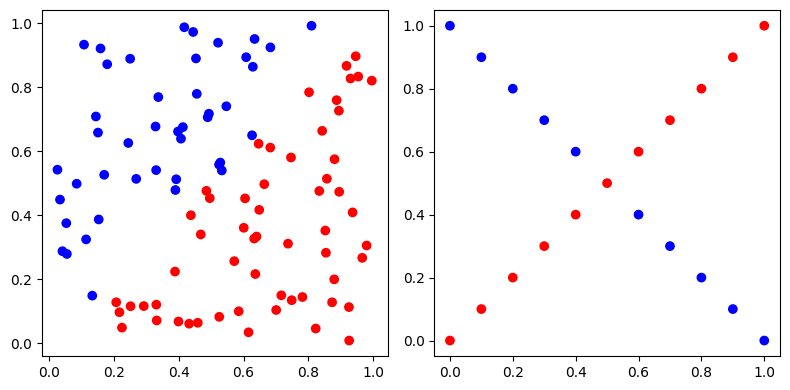

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

x, y = generate_linear(n=100)
colors = ['r' if label == 0 else 'b' for label in y]
axs[0].scatter(x[:, 0], x[:, 1], c=colors)

x, y = generate_XOR_easy()
colors = ['r' if label == 0 else 'b' for label in y]
axs[1].scatter(x[:, 0], x[:, 1], c=colors)

plt.show()

# Plot Results' function

In [4]:
def show_result(x, y, y_pred, prtTxt=False):
    plt.subplot(1, 2, 1)
    plt.title('Ground truth', fontsize=18)
    
    m = y.shape[0]
    corr = 0
    
    for i in range(m):
        if prtTxt:
            print(f'GT: {y[i]}, pred: {y_pred[i]}')
        if (abs(y[i] - y_pred[i]) < 0.5):
            corr += 1
    
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    
    plt.subplot(1, 2, 2)
    plt.title('Predict result\nacc = %.2f%%' % (corr / m * 100), fontsize=18)
    for i in range(x.shape[0]):
        if y_pred[i] < 0.5:
            plt.plot(x[i][0], x[i][1], 'ro')
        elif y_pred[i] > 0.5:
            plt.plot(x[i][0], x[i][1], 'bo')
        else:
            plt.plot(x[i][0], x[i][1], 'go')
    
    plt.show()

# Model

## Initialization

In [5]:
def init_param(layer_dim):
    param = []
    for i in range(1, len(layer_dim)):
        param.append(np.random.randn(layer_dim[i-1], layer_dim[i]) * 0.1)
    
    return param

## Single block

In [6]:
def linear(A, W):
    Z = A @ W
    cache = (A, W)
    return Z, cache

def sigmoid(Z):
    Z_clipped = np.clip(Z, -500, 500)
    A = 1. / (1.+np.exp(-Z_clipped))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(Z, 0)
    cache = Z
    return A, cache

def linear_backward(dZ, cache):
    A_prev, W = cache
    m = A_prev.shape[0]
    
    dW = (1./m) * A_prev.T @ dZ
    dA_prev = dZ @ W.T
    
    return dA_prev, dW

def sigmoid_backward(dA, cache):
    Z = cache
    s, _ = sigmoid(Z)
    dZ = dA * s * (1.-s)
    return dZ

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

## Layer: linear & activation

In [7]:
def linear_activation_forward(A_prev, W, activation='sigmoid'):
    A, l_cache = linear(A_prev, W)
    
    a_cache=0
    if activation == 'sigmoid':
        A, a_cache = sigmoid(A)
    elif activation == 'relu':
        A, a_cache = relu(A)
    
    cache = (l_cache, a_cache)
    
    return A, cache

def linear_activation_backward(dA, cache, activation='sigmoid'):
    l_cache, a_cache = cache
    
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, a_cache)
    elif activation == 'relu':
        dZ = relu_backward(dA, a_cache)
    else:
        dZ = dA
    
    dA_prev, dW = linear_backward(dZ, l_cache)
    
    return dA_prev, dW

## Multi-Layer

In [8]:
def L_model_forward(x, param, activations):
    A = x
    caches = []
    for i in range(len(param)):
        A, cache = linear_activation_forward(A, param[i], activations[i])
        caches.append(cache)
    
    return A, caches

def L_model_backward(y, y_pred, caches, activations):
    grads = []
    m = y.shape[0]
    
    dA = y_pred - y
    
    for i in range(len(caches)-1, -1, -1):
        dA, dW = linear_activation_backward(dA, caches[i], activations[i])
        grads.insert(0, dW)
    
    return grads

## Optimization

In [9]:
def update_param(param, grads, learning_rate):
    for i in range(len(param)):
        param[i] -= learning_rate * grads[i]
    return param

def init_momentum(param):
    v = []
    for i in range(len(param)):
        v.append(np.zeros_like(param[i]))
    return v

def update_param_momentum(param, v, grads, learning_rate, beta=0.9):
    for i in range(len(v)):
        v[i] = beta * v[i] + (1.-beta) * grads[i]
        param[i] -= learning_rate * v[i]
    
    return param, v

def init_adam(param):
    t = 1
    v = []
    s = []
    for i in range(len(param)):
        v.append(np.zeros_like(param[i]))
        s.append(np.zeros_like(param[i]))
    
    return v, s, t

def update_param_adam(param, v, s, t, grads, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    for i in range(len(v)):
        v[i] = beta1*v[i] + (1.-beta1)*grads[i]
        v_corr = v[i] / (1.-beta1**t)
        
        s[i] = beta2*s[i] + (1.-beta2)*(grads[i]**2)
        s_corr = s[i] / (1.-beta2**t)
        
        param[i] -= learning_rate * (v_corr / (np.sqrt(s_corr) + epsilon))
    
    return param, v, s, t+1
        

## Cost function

In [10]:
def compute_cost(y, y_pred):    
    m = y.shape[0]
    
    diff = np.abs(y - y_pred)
    cost = 1./m * np.sum(diff)
    
    return cost

## Model Main

In [11]:
def predict(x, param, activations=['relu','relu','sigmoid']):
    y_pred, caches = L_model_forward(x, param, activations)
    return y_pred

def model(x, y, epoch=10, layer_dim=[2,4,4,1], activations=['relu','relu','sigmoid'], 
          learning_rate=0.1, batch_size=16, rand_batch=False, 
          optimizer='gd', beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    
    param = init_param(layer_dim)
    if optimizer == 'momentum':
        v = init_momentum(param)
    elif optimizer == 'adam':
        v, s, t = init_adam(param)
    
    costs = []
    m = y.shape[0]
    idx = [i for i in range(m)]
    
    for k in range(epoch):
        random.shuffle(idx)
        for i in range(m // batch_size + 1):
            mini_x = x[idx[i*batch_size:(i+1)*batch_size]]
            mini_y = y[idx[i*batch_size:(i+1)*batch_size]]
            
            y_pred, caches = L_model_forward(mini_x, param, activations)
            grads = L_model_backward(mini_y, y_pred, caches, activations)
            
            if optimizer == 'gd':
                param = update_param(param, grads, learning_rate)
            elif optimizer == 'momentum':
                param, v = update_param_momentum(param, v, grads, learning_rate, beta)
            elif optimizer == 'adam':
                param, v, s, t = update_param_adam(param, v, s, t, grads, learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
        
        y_pred = predict(x, param, activations)
        if k % 10 == 0:
            cost = compute_cost(y, y_pred)
            costs.append(cost)
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return param

# Training & Testing

## Linear test case

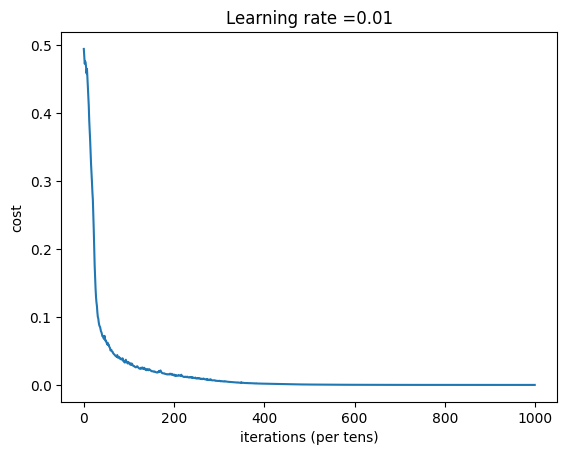

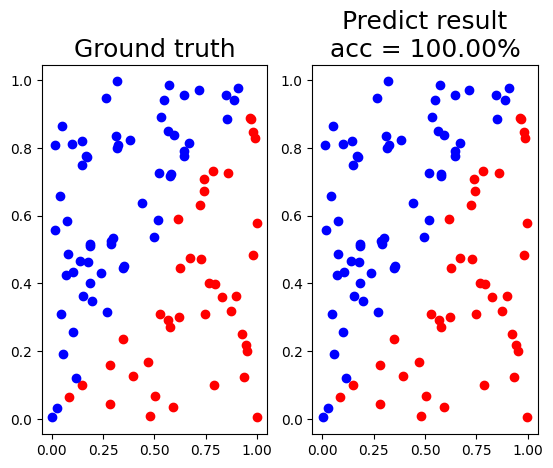

GT: [1], pred: [1.]
GT: [1], pred: [0.98476371]
GT: [0], pred: [6.88338148e-12]
GT: [1], pred: [1.]
GT: [0], pred: [6.86265409e-12]
GT: [1], pred: [1.]
GT: [0], pred: [6.85284078e-12]
GT: [0], pred: [6.88457351e-12]
GT: [0], pred: [1.43586102e-09]
GT: [0], pred: [6.86030405e-12]


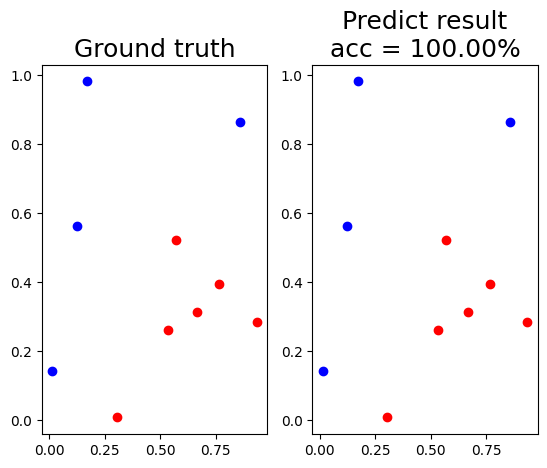

In [12]:
# modify here
n = 100
epoch = 10000
layer_dim = [2, 4, 4, 1]
activations = ['sigmoid', 'sigmoid', 'sigmoid']
learning_rate = 0.01
batch_size = 32
rand_batch = True
optimizer = 'adam'
beta = 0.7
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Training
x, y = generate_linear(n=n)
param = model(x, y, epoch=epoch, layer_dim=layer_dim, activations=activations, 
              learning_rate=learning_rate, batch_size=batch_size, rand_batch=rand_batch, 
              optimizer=optimizer, beta=beta, beta1=beta1, beta2=beta2, epsilon=epsilon)
y_pred = predict(x, param, activations=activations)
show_result(x, y, y_pred)

# Testing
x, y = generate_linear(n=10)
y_pred = predict(x, param, activations=activations)
show_result(x, y, y_pred, prtTxt=True)

## accuracy

10000 epoch
learning rate 0.01
batch_size 32

| network | gd | momentum | adam |
| ----- | ----- | ----- | ----- |
| 2,1s | 98, 100 | 99, 100 | 100, 100 |
| 2,4s,1s | 76, 60 | 99, 90 | 100, 100 |
| 2,4s,4s,1s | 53, 60 | 52, 60 | 100, 100 |
| 2,4s,4s,4s,1s | 53, 30 | 54, 40 | 100, 100 |
| 2,4r,1s | 99, 100 | 100, 100 | 100, 100 |
| 2,4r,4r,1s | 45, 20 | 55, 40 | 43, 50 |
| 2,4,1s | 100, 100 | 97, 90 | 100, 100 |
| 2,4,4,1s | 100, 100 | 99, 100 | 100, 100 |
| 2,4,4,4,1s | 88, 90 | 87, 80 | 100, 100 |

## XOR test case

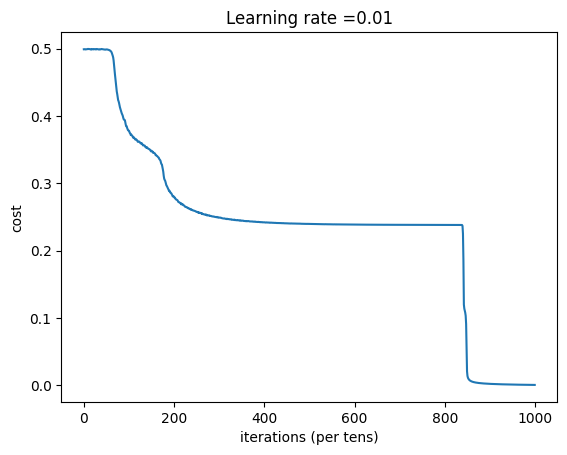

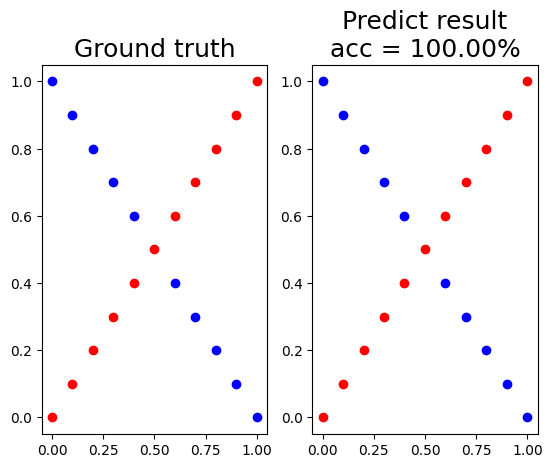

In [13]:
# modify here
epoch = 10000
layer_dim = [2, 4, 4, 1]
activations = ['sigmoid', 'sigmoid', 'sigmoid']
learning_rate = 0.01
batch_size = 8
rand_batch = True
optimizer = 'adam'
beta = 0.9
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Training
x, y = generate_XOR_easy()
param = model(x, y, epoch=epoch, layer_dim=layer_dim, activations=activations, 
              learning_rate=learning_rate, batch_size=batch_size, rand_batch=rand_batch, 
              optimizer=optimizer, beta=beta, beta1=beta1, beta2=beta2, epsilon=epsilon)
y_pred = predict(x, param, activations=activations)

show_result(x, y, y_pred)